2023/08/15

# Autoencoder
- [Reducing the Dimensionality of Data with Neural Networks (Hinton & Salakhutdinov, 2006)](https://www.science.org/doi/full/10.1126/science.1127647)
- 多次元データをNNで少数次元に圧縮し，再度そこから元の多次元データを再構築する．

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
# データセット
from torchvision import transforms, datasets
dataset = datasets.MNIST("~/data/", transform=transforms.ToTensor(), download=True)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [3]:
# モデル
class Encoder(torch.nn.Module):
    def __init__(self, nh, nz):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, nh)
        self.fc2 = torch.nn.Linear(nh, nz)

    def forward(self, x):
        h = self.fc1(x).relu()
        z = self.fc2(h).sigmoid()
        return z

class Decoder(torch.nn.Module):
    def __init__(self, nh, nz):
        super().__init__()
        self.fc1 = torch.nn.Linear(nz, nh)
        self.fc2 = torch.nn.Linear(nh, 784)

    def forward(self, z):
        h = self.fc1(z).relu()
        x = self.fc2(h).sigmoid()
        return x

class Autoencoder(torch.nn.Module):
    def __init__(self, nh=1024, nz=2):
        super().__init__()
        self.encoder = Encoder(nh, nz)
        self.decoder = Decoder(nh, nz)

    def forward(self, x):
        z = self.encoder(x.flatten(1))
        x = self.decoder(z).view_as(x)
        return x, z

tensor([[0.5141, 0.4735]], device='cuda:0')


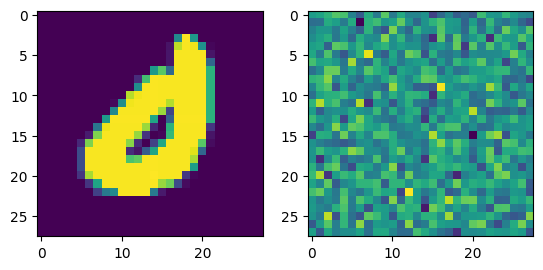

In [4]:
# 元画像と再構成画像・潜在表現（学習前）
model = Autoencoder().cuda()

x0 = next(iter(loader))[0][0]       # 0枚目の画像
with torch.no_grad():
    x0_pred, z = model(x0.cuda())

fig, axes = plt.subplots(1, 2)
axes[0].imshow(x0.permute(1, 2, 0)) # 元画像
axes[1].imshow(x0_pred.cpu().permute(1, 2, 0))  # 再構成画像
print(z)    # 潜在表現

In [5]:
# 学習
optimizer = torch.optim.Adam(model.parameters())
for epoch in range(10):
    n = loss_tot = 0
    for x, _y in loader:
        x = x.cuda()
        loss = torch.nn.functional.mse_loss(model(x)[0], x)
        model.zero_grad()
        loss.backward()
        optimizer.step()

        n += len(x)
        loss_tot += len(x) * float(loss)
        print(f"loss: {loss_tot/n:.4f}", end="\r")
    print()

loss: 0.0578
loss: 0.0487
loss: 0.0463
loss: 0.0451
loss: 0.0443
loss: 0.0437
loss: 0.0432
loss: 0.0429
loss: 0.0426
loss: 0.0422


tensor([[1.0000, 0.1971]], device='cuda:0')


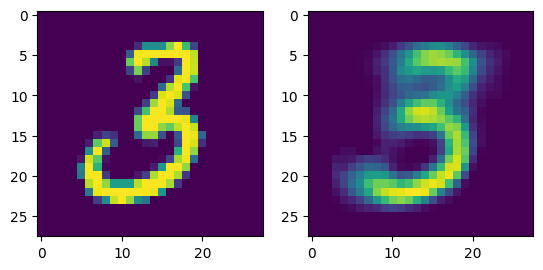

In [6]:
# 元画像と再構成画像・潜在表現（学習後）
x0 = next(iter(loader))[0][0]       # 0枚目の画像
with torch.no_grad():
    x0_pred, z = model(x0.cuda())

fig, axes = plt.subplots(1, 2)
axes[0].imshow(x0.permute(1, 2, 0)) # 元画像
axes[1].imshow(x0_pred.cpu().permute(1, 2, 0))   # 再構成画像
print(z)    # 潜在表現

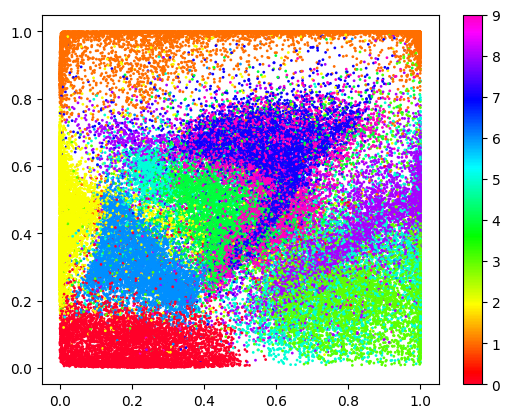

In [7]:
# 潜在空間におけるデータ（ラベル）の分布（各画像をエンコードしてみる）
x, y = dataset._load_data()
with torch.no_grad():
    z = model.encoder(x.cuda().flatten(1)/255).cpu()

plt.scatter(z[:, 0], z[:, 1], 1, y, cmap="gist_rainbow")
plt.colorbar()

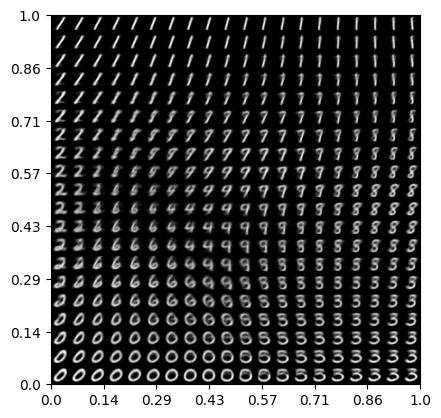

In [8]:
# 潜在表現に対する再構築した画像の分布

# 各軸の分割数
nrows = 20
ncols = 20
# 軸の端
axmin = 0
axmax = 1

with torch.no_grad():
    ax = torch.linspace(axmin, axmax, nrows)
    z = torch.cartesian_prod(ax, ax).cuda()
    x0_pred = model.decoder(z).reshape(nrows, ncols, 28, 28).rot90(dims=(0, 1)).cpu()

plt.imshow(torch.hstack(tuple(torch.hstack(tuple(x0_pred)))), "gray")
plt.xticks(np.arange(0, 28*ncols+1, 4*ncols), np.linspace(axmin, axmax, 8).round(2))
plt.yticks(np.arange(0, 28*nrows+1, 4*nrows), np.linspace(axmax, axmin, 8).round(2))
plt.show()